In [ ]:
import torch
import numpy as np
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [ ]:
class BrakeForObstacleEnv:
  """Toy environment.

  Action space: binary
  Observation space: [obstacle, brake light, distractors]

  The obstacle feature is a binary feature indicating if an obstacle is present.
  The brake light indicates if the brake was applied in the prior timestep.
  Distractors are irrelevant noise.

  The optimal policy is to brake when an obstacle is present and not brake otherwise.
  """
  def __init__(self):
    self.last_step_had_obstacle = False
    self.n_distactors = 3
    self.prob_obstacle_appears = 0.1
    self.prob_obstacle_gone = 0.025

  def step(self, action: torch.Tensor):
    assert action.shape == (1,)

    # The brake light indicator.
    braking = action > 0.

    if self.last_step_had_obstacle and torch.rand(1) < self.prob_obstacle_gone:
      self.last_step_had_obstacle = False
    elif not self.last_step_had_obstacle and torch.rand(1) < self.prob_obstacle_appears:
      self.last_step_had_obstacle = True

    distractors = torch.rand(self.n_distactors)

    obs = torch.concat([torch.tensor([self.last_step_had_obstacle, braking], dtype=torch.float32), distractors])

    return obs

def optimal_policy(obs):
  # The optimal policy ignores every entry in the observation except whether
  # and obstacle is present or not.
  if obs[0]:
    return torch.tensor([1.], dtype=torch.float32)
  else:
    return torch.tensor([0.], dtype=torch.float32)


In [ ]:
def eval_causality(policy):
  should_start_braking_obs = torch.tensor([1, 0, 0, 0, 0], dtype=torch.float32)
  should_stop_braking_obs = torch.tensor([0, 1, 0, 0, 0], dtype=torch.float32)
  assert optimal_policy(should_start_braking_obs) == 1
  assert optimal_policy(should_stop_braking_obs) == 0
  p_should_start = policy(should_start_braking_obs).item()
  p_should_stop = policy(should_stop_braking_obs).item()
  causal_correctness = np.log(p_should_start) - np.log(p_should_stop)
  return causal_correctness

def train(learned_policy):
  optimal_action = torch.tensor([0.], dtype=torch.float32)
  env = BrakeForObstacleEnv()
  step_nos = []
  causal_correctnesses = []


  for i in range(10000000):
    obs = env.step(optimal_action)
    optimal_action = optimal_policy(obs)

    obs = obs.clone()
    pred_act = learned_policy(obs)
    loss = F.binary_cross_entropy(pred_act, target=optimal_action)
    loss.backward()

    with torch.no_grad():
      for param in learned_policy.parameters():
        param -= 0.0001 * param.grad
        # param *= (1.0 - 0.0001)

    learned_policy.zero_grad()

    if (i % 10000) == 0:
      step_nos.append(i)
      causal_correctnesses.append(eval_causality(learned_policy))

  return (step_nos, causal_correctnesses)


In [ ]:
# Here we construct a near-optimal linear policy to demonstrate its existence.

optimal_linear_policy = nn.Sequential(
    nn.Linear(5, 1),
    nn.Sigmoid()
)
optimal_linear_policy[0].weight.requires_grad = False
optimal_linear_policy[0].weight[:] = torch.tensor([20.] + [0.]*4)
optimal_linear_policy[0].bias.requires_grad = False
optimal_linear_policy[0].bias[:] = torch.tensor(-10)
eval_causality(optimal_linear_policy)

np.float64(9.999999909301904)

In [ ]:
results_different_depths = {}
obs_D = 5

def build_model(input_dim, hidden_dim, depth):
    layers = []

    # Special case for 0 depth (Linear model).
    if depth == 0:
        layers.append(nn.Linear(input_dim, 1, bias=False))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    # Input layer
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.ReLU())

    # Hidden layers (we add depth - 1 because the input layer counts as the first level of "width")
    for _ in range(depth - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.ReLU())

    # Output layer
    layers.append(nn.Linear(hidden_dim, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)


results_different_depths = {}
depths_to_test = [0, 1, 2, 3, 4] # 0 is linear, 1 is mlp_10, 2 is mlp_10x2, etc.
hidden_dim = 10

for depth in depths_to_test:
    # Create a dynamic name (e.g., "linear", "mlp_10", "mlp_10x2")
    if depth == 0:
        name = "linear"
    elif depth == 1:
        name = f"mlp_{hidden_dim}"
    else:
        name = f"mlp_{hidden_dim}x{depth}"

    results_different_depths[name] = []

    print(f"Training architecture: {name}")

    for i in range(3):
        # Initialize a fresh policy instance
        policy = build_model(obs_D, hidden_dim, depth)

        # Train and store
        results_different_depths[name].append(train(policy))


Training architecture: linear
Training architecture: mlp_10
Training architecture: mlp_10x2
Training architecture: mlp_10x3


In [ ]:
torch.save(results_different_depths, "/content/results3.torch")

<Figure size 1000x600 with 0 Axes>

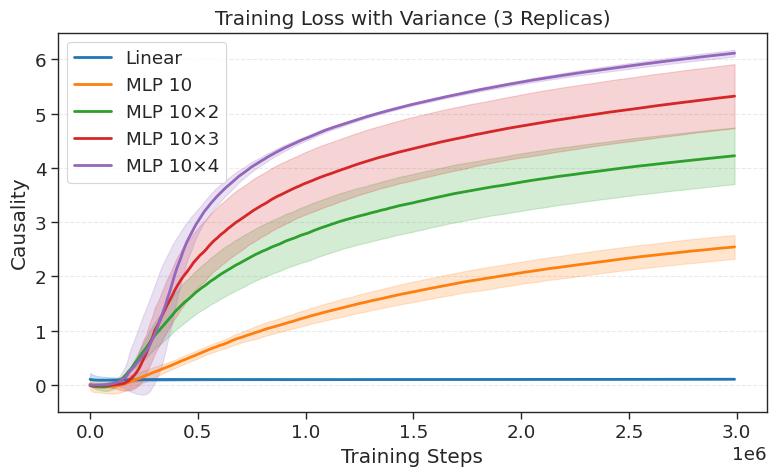

In [ ]:
plt.figure(figsize=(10, 6))

to_include = ['linear', 'mlp_10', 'mlp_10x2', 'mlp_10x3', 'mlp_10x4']
to_plot = {k: v for k, v in results_different_depths.items() if k in to_include}

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks") # 'whitegrid' is also good, but 'ticks' is cleaner for journals

fig, ax = plt.subplots(figsize=(8, 5))

# Define a nice color palette
colors = sns.color_palette("tab10", n_colors=len(to_include))

for i, (model_name, replicas) in enumerate(to_plot.items()):
    # 1. Extract Data
    # Assuming all replicas ran for the same number of epochs.
    # We take the x-axis (epochs) from the first replica.
    steps = np.array(replicas[0][0])

    # Stack the y-axes (losses) into a 2D Matrix
    # Shape becomes: (10 rows, Num_Epochs columns)
    all_losses = np.array([r[1] for r in replicas])

    # 2. Compute Statistics (axis=0 means "down the columns"/across replicas)
    mean_loss = all_losses.mean(axis=0)
    std_loss = all_losses.std(axis=0)

    if "mlp" in model_name:
        label_str = model_name.replace("mlp_", "MLP ").replace("x", "×")
    else:
        label_str = model_name.capitalize()

    # 3. Plot Mean Line
    # We capture the line object 'p' to get its color later
    p = ax.plot(steps, mean_loss, label=label_str, color=colors[i], linewidth=2)
    color = p[0].get_color()

    # 4. Plot Variance Shading
    # We shade between (Mean - Std) and (Mean + Std)
    plt.fill_between(steps,
                     mean_loss - std_loss,
                     mean_loss + std_loss,
                     color=color, alpha=0.2) # alpha makes it transparent

plt.xlabel('Training Steps')
plt.ylabel('Causality')
plt.title('Training Loss with Variance (3 Replicas)')
plt.legend()
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('toy_problem.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()